In [375]:
import csv
import math
import matplotlib.pyplot as plt

class POI:
    def __init__(self, id, name, latitude, longitude, type_code, category):
        self.id = id
        self.name = name
        self.latitude = latitude
        self.longitude = longitude
        self.type_code = type_code
        self.category = category
        

In [376]:
from math import sin, cos, sqrt, atan2, radians
def degrees_to_meters(lat1, lon1, lat2, lon2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance between two points in meters
    distance = R * c * 1000
    return distance

In [377]:
class IndexBuilding:
    def __init__(self, file_path):
        self.poi_list = []
        self.poi_matrix = []
        
        self.diff_latitude = 0
        self.diff_longitude = 0
        
        self.step_latitude = 0
        self.step_longitude = 0
        
        self.min_latitude = 0
        self.min_longitude = 0
        
        self.max_latitude = 0
        self.max_longitude = 0
        
        self.boarders = 10
             
        self.build_index_brute_force(file_path)
        self.build_spatial_index()
        
    # An index-building function (for brute force)
    def build_index_brute_force(self, file_path):
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row
            id = -1
            for row in reader:
                id += 1
                name = row[0]
                latitude = float(row[1])
                longitude = float(row[2])
                type_code = row[3]
                category = row[4]
                poi = POI(id, name, latitude, longitude, type_code, category)
                self.poi_list.append(poi)
    
    # An index-building function (for spatial)
    def build_spatial_index(self):
        max_latitude = max(poi.latitude for poi in self.poi_list)
        max_longitude = max(poi.longitude for poi in self.poi_list)
        min_latitude = min(poi.latitude for poi in self.poi_list)
        min_longitude = min(poi.longitude for poi in self.poi_list)
        
        diff_latitude = max_latitude - min_latitude
        diff_longitude = max_longitude - min_longitude
        
        step_latitude = diff_latitude / self.boarders
        step_longitude = diff_longitude / self.boarders
        
        poi_matrix = [[[] for _ in range(self.boarders + 1)] for _ in range(self.boarders + 1)]
    
        for poi in self.poi_list:
            i = int((poi.longitude - min_longitude) // step_longitude)
            j = int((poi.latitude - min_latitude) // step_latitude)
            poi_matrix[i][j].append(poi) 
            
        self.poi_matrix = poi_matrix
        
        self.step_latitude = step_latitude
        self.step_longitude = step_longitude
        
        self.min_latitude = min_latitude
        self.min_longitude = min_longitude
        
        self.max_latitude = max_latitude
        self.max_longitude = max_longitude
        
        self.diff_latitude = diff_latitude
        self.diff_longitude = diff_longitude
        
    # A brute-force range query function
    def range_scan(self, query_range, type_regex_str):
        result = []
        for poi in self.poi_list:
            if query_range.contains(poi.latitude, poi.longitude) and poi.type_code.startswith(type_regex_str):
                result.append(poi)
        return result
    
    # A brute-force nearest neighbor query function
    def nearest_neighbors_scan(self, query_point, type_regex_str):
        result = None
        min_distance = 9999 # meters 
        for poi in self.poi_list:
            if poi.type_code.startswith(type_regex_str):
                distance = degrees_to_meters(query_point.latitude, query_point.longitude, poi.latitude, poi.longitude)
                if distance < min_distance:
                    min_distance = distance
                    result = poi
        return result
    
    # A nearest neighbor query function based on the spatial index
    def nearest_neighbors_query(self, query_point, type_regex_str):
    
        # Index of query point in our matrix (spatial indexing)
        i = int((query_point.longitude - self.min_longitude) // self.step_longitude) - 1
        j = int((query_point.latitude - self.min_latitude) // self.step_latitude) - 1
        
        # Calculating the coordinates of the sides of the box (cell) where query point is located
        down = self.min_longitude + i * self.step_longitude
        up = down + self.step_longitude
        left = self.min_latitude + j * self.step_latitude
        right = left + self.step_latitude
        
        # Calculating the distances from query point to the boarders of the cell
        # To check do we need to check adjacent cells
        distance_to_left = degrees_to_meters(query_point.latitude, query_point.longitude, left, query_point.longitude)
        distance_to_right = degrees_to_meters(query_point.latitude, query_point.longitude, right, query_point.longitude)
        distance_to_up = degrees_to_meters(query_point.latitude, query_point.longitude, query_point.latitude, up)
        distance_to_down = degrees_to_meters(query_point.latitude, query_point.longitude, query_point.latitude, down)
        
        result = None
        min_distance = 9999 # meters
        for poi in self.poi_matrix[i][j]:
            if poi.type_code.startswith(type_regex_str):
                distance = degrees_to_meters(query_point.latitude, query_point.longitude, poi.latitude, poi.longitude)
                if distance < min_distance:
                    min_distance = distance
                    result = poi
    
        return result
    
    # A range query function based on the spatial index
    def range_query(self, query_range, type_regex_str):
        
        max_longitude = query_range.upper_left.longitude
        if max_longitude > self.max_longitude: max_longitude = self.max_longitude
            
        min_longitude = query_range.bottom_right.longitude
        if min_longitude < self.min_longitude: min_longitude = self.min_longitude
        
        max_latitude = query_range.bottom_right.latitude
        if max_latitude > self.max_latitude: max_latitude = self.max_latitude
        
        min_latitude = query_range.upper_left.latitude
        if min_latitude < self.min_latitude: min_latitude = self.min_latitude
        
        min_j = int((min_latitude - self.min_latitude) // self.step_latitude)
        max_j = int((max_latitude - self.min_latitude) // self.step_latitude)
        
        min_i = int((min_longitude - self.min_longitude) // self.step_longitude)
        max_i = int((max_longitude - self.min_longitude) // self.step_longitude)
        
        
        result = []
        for i in range(min_i, max_i + 1):
            for j in range(min_j, max_j + 1):
                for poi in self.poi_matrix[i][j]:
                    if (query_range.contains(poi.latitude, poi.longitude) 
                            and poi.type_code.startswith(type_regex_str)):
                        result.append(poi)
        return result
                

In [378]:
class Rectangle:
    def __init__(self, upper_left, bottom_right):
        self.upper_left = upper_left
        self.bottom_right = bottom_right
        
    def __init__(self, center, side_length_meters):
        self.center = center
        self.side_length_meters = side_length_meters

        # Calculate the half side length in meters
        half_side_length_meters = side_length_meters / 2

        # Calculate the latitude and longitude offsets for the rectangle
        lat_offset = (180 / math.pi) * (half_side_length_meters / 6373000)
        lon_offset = (180 / math.pi) * (half_side_length_meters / 6373000) / math.cos(math.radians(center.latitude))

        # Calculate the upper left and bottom right points of the rectangle
        self.upper_left = Point(center.latitude - lat_offset, center.longitude + lon_offset)
        self.bottom_right = Point(center.latitude + lat_offset, center.longitude - lon_offset)
    
    # Checking if rectangle contains poijnt
    def contains(self, latitude, longitude):
        return (self.bottom_right.latitude >= latitude >= self.upper_left.latitude and
                self.bottom_right.longitude <= longitude <= self.upper_left.longitude)

In [379]:
class Point:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude

In [380]:
# Index building
index = IndexBuilding('Assignment2-2012_BIT_POI.csv')

In [381]:
# Searching for the nearest ATM with spatial indexing
type_regex_str = "1603"
query_point = Point(39.958, 116.311)
res = index.nearest_neighbors_query(query_point, type_regex_str)
print("Nearest ATM around Central Building of BIT (spatial indexing):")
print(f"ID: {res.id}, Latitude: {res.latitude}, Longitude: {res.longitude}, Type Code: {res.type_code}")

Nearest ATM around Central Building of BIT (spatial indexing):
ID: 1120, Latitude: 39.9565121976451, Longitude: 116.31054154116, Type Code: 160306


In [382]:
# Searching for the nearest ATM with brute force
res = index.nearest_neighbors_scan(query_point, type_regex_str)
print("Nearest ATM around Central Building of BIT (brute-force):")
print(f"ID: {res.id}, Latitude: {res.latitude}, Longitude: {res.longitude}, Type Code: {res.type_code}")

Nearest ATM around Central Building of BIT (brute-force):
ID: 1120, Latitude: 39.9565121976451, Longitude: 116.31054154116, Type Code: 160306


In [383]:
# Searching for the restaurants in 500x500 meters square with brute force 
query_point = Point(39.955, 116.310)
query_range = Rectangle(query_point, 500)
type_regex_str = "5"
res = index.range_scan(query_range, type_regex_str)
print("Nearest restaurants to the south door of BIT:")
print(f"Count of restaurants in 500x500 meters square: {len(res)}")
for poi in res:
    print(f"ID: {poi.id}, Latitude: {poi.latitude}, Longitude: {poi.longitude}, Type Code: {poi.type_code}")

Nearest restaurants to the south door of BIT:
Count of restaurants in 500x500 meters square: 27
ID: 8, Latitude: 39.954419455158, Longitude: 116.310981826996, Type Code: 50500
ID: 33, Latitude: 39.9537194425661, Longitude: 116.31206649601, Type Code: 50100
ID: 41, Latitude: 39.9560135808697, Longitude: 116.311413664664, Type Code: 50400
ID: 62, Latitude: 39.9545775874651, Longitude: 116.310907971271, Type Code: 50100
ID: 65, Latitude: 39.9536057693156, Longitude: 116.312425706112, Type Code: 50100
ID: 67, Latitude: 39.9531347054657, Longitude: 116.31140803998, Type Code: 50000
ID: 70, Latitude: 39.9559018183109, Longitude: 116.312351582772, Type Code: 50500
ID: 71, Latitude: 39.9536186953279, Longitude: 116.312464617278, Type Code: 50100
ID: 73, Latitude: 39.954466788069, Longitude: 116.311336032598, Type Code: 50300
ID: 135, Latitude: 39.9532334862187, Longitude: 116.309385509306, Type Code: 50100
ID: 136, Latitude: 39.9539428800236, Longitude: 116.310765368082, Type Code: 50121
ID: 1

In [384]:
# Searching for the restaurants in 500x500 meters square with spatial indexing 
query_point = Point(39.955, 116.310)
query_range = Rectangle(query_point, 500)
type_regex_str = "5"
res = index.range_query(query_range, type_regex_str)
print("Nearest restaurants to the south door of BIT:")
print(f"Count of restaurants in 500x500 meters square: {len(res)}")
for poi in res:
    print(f"ID: {poi.id}, Latitude: {poi.latitude}, Longitude: {poi.longitude}, Type Code: {poi.type_code}")

Nearest restaurants to the south door of BIT:
Count of restaurants in 500x500 meters square: 27
ID: 135, Latitude: 39.9532334862187, Longitude: 116.309385509306, Type Code: 50100
ID: 136, Latitude: 39.9539428800236, Longitude: 116.310765368082, Type Code: 50121
ID: 257, Latitude: 39.9539129496867, Longitude: 116.310194637276, Type Code: 50100
ID: 195, Latitude: 39.9555118235525, Longitude: 116.309155728038, Type Code: 50117
ID: 251, Latitude: 39.9555089794922, Longitude: 116.309071912655, Type Code: 50118
ID: 258, Latitude: 39.9555091445122, Longitude: 116.308983107752, Type Code: 50118
ID: 8, Latitude: 39.954419455158, Longitude: 116.310981826996, Type Code: 50500
ID: 33, Latitude: 39.9537194425661, Longitude: 116.31206649601, Type Code: 50100
ID: 65, Latitude: 39.9536057693156, Longitude: 116.312425706112, Type Code: 50100
ID: 67, Latitude: 39.9531347054657, Longitude: 116.31140803998, Type Code: 50000
ID: 71, Latitude: 39.9536186953279, Longitude: 116.312464617278, Type Code: 50100


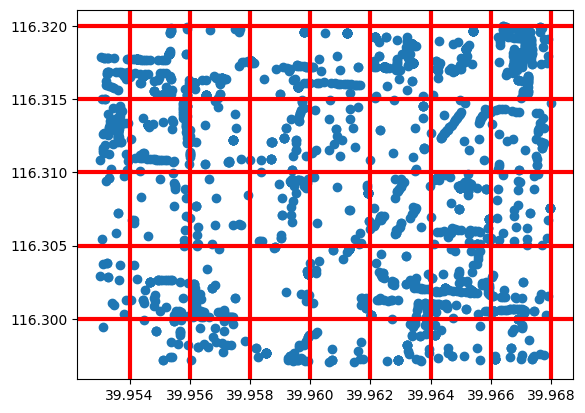

In [385]:
x = [ind.latitude for ind in index.poi_list]
y = [ind.longitude for ind in index.poi_list]
plt.scatter(x, y)
plt.grid(color="r", linewidth=3)